In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.datamodules import chipmultilabel
from earthtext.models import osmencoder
from importlib import reload
reload(chipmultilabel)
reload(osmencoder)

<module 'earthtext.models.osmencoder' from '/home/ubuntu/earth-text/src/earthtext/models/osmencoder.py'>

## setup dataloader

In [2]:
#conf = OmegaConf.load("../../configs/osmencoder-abs-logrsme-1epoch.yaml")
conf = OmegaConf.load("../../configs/naip-osmencoder.yaml")
dl = hydra.utils.instantiate(conf.dataloader)

2024-05-16 02:58:26.828 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:96 - using embeddings found in metadata file
2024-05-16 02:58:26.830 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:109 - read train split with 72268 chip files (out of 72268)
2024-05-16 02:58:26.830 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:114 - max cache size is -1
2024-05-16 02:58:28.771 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:96 - using embeddings found in metadata file
2024-05-16 02:58:28.773 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:109 - read val split with 14770 chip files (out of 14770)
2024-05-16 02:58:28.773 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:114 - max cache size is -1
2024-05-16 02:58:30.682 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:96 - using embeddings found in metadata file
2024-05-16 02:58:30.684 | INFO     

In [4]:
import pickle
with open("/opt/data/california-naip-chips/california-naip-chips-100k_metadata_embeddings_meansstdevs.pkl", "rb") as f:
    z = pickle.load(f)

In [10]:
b = dl.train_dataset[0]

In [11]:
b.keys()

dict_keys(['multilabel', 'embedding', 'osm_strlabels', 'osm_ohearea', 'osm_ohecount', 'osm_ohelength'])

## setup model and optimizer

In [14]:
conf = OmegaConf.load("../../configs/naip-osmencoder.yaml")

eps = 1e-5


loss_funcs = {
    'rmse': lambda a,b: torch.sqrt(torch.mean( (a - b)**2 )),
    'mse': lambda a,b: torch.mean( (a - b)**2 ),
    
}

dltrain = dl.train_dataloader()

m = hydra.utils.instantiate(conf.model)

optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
#optimizer = torch.optim.RMSprop(m.parameters(), lr=1e-5)

loss_fn = loss_funcs[conf.training.loss]

dl.disable_chip_loading()

sum([np.product(p.shape) for p in m.parameters()]), conf.training.epochs

(4350720, 1)

In [15]:
m.layers

Sequential(
  (0): Linear(in_features=297, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=2048, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2048, out_features=768, bias=True)
)

In [16]:
conf.training.loss

'rmse'

In [18]:
from datetime import datetime
models_folder = "/opt/data/models/"
embeddings_version = 'naip'
nowstr = datetime.today().strftime("%Y-%m-%d_%H:%M")
model_name = f"osm_emcoder__{embeddings_version}__trainedon_{nowstr}"
model_conf_fname = f"{models_folder}/{model_name}.yaml"
model_ckpt_fname = f"{models_folder}/{model_name}.ckpt"

In [19]:
model_name

'osm_emcoder__naip__trainedon_2024-05-16_03:01'

In [39]:
dl.disable_chip_loading()
dltrain = dl.train_dataloader()
dltrain.dataset.embeddings_normalization

True

## train loop

In [21]:
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)


In [ ]:
n_epochs = conf.training.epochs
n_epochs = 1000

lossh = []
rmseh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        t = batch['embedding']

        # run model
        o = m(batch)

        # compute losses (complex mse or rmse)
        loss_base = loss_fn(t,o)
        loss_reg = torch.sum(torch.stack([(p.abs().mean()) for p in m.parameters()]))

        rmse = loss_funcs['rmse'](t,o)        
        
        #loss_variance = torch.sqrt(torch.mean((t.std(axis=0) - o.std(axis=0))**2))
        output_stdev = (o.std(axis=0)+1e-5).mean()
        loss = loss_base + 10*loss_reg
        
        # backpropage and sigmoidupdate
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        rmsen = rmse.detach().cpu().numpy()
        lossh.append(lossn)
        rmseh.append(rmsen)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-500:])
        rmsem = np.mean(rmseh[-500:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} rmse {rmsem:.5f} params {loss_reg:.7f} output_stdev {output_stdev.detach().numpy():.5f}", end="\r")

        OmegaConf.save(conf, model_conf_fname)
        torch.save(m.state_dict(), model_ckpt_fname)
        
        #if loss < 0.5:
        #    print ("low loss!!")
        #    break
    #print()

/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py:183: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x708646f78860>
Traceback (most recent call last):
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/conda/envs/earth-text-env/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x708646f78860>
Traceback (most recent call last):
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/earth-text-env/lib/py

In [35]:
models_folder = "/opt/data/models/"

In [42]:
# save model
from datetime import datetime
models_folder = "/opt/data/models/"
embeddings_version = conf.dataloader.embeddings_folder.split("/")[-1]
nowstr = datetime.today().strftime("%Y-%m-%d_%H:%M")
#model_name = f"osm_emcoder__{embeddings_version}__trainedon_{nowstr}"
model_conf_fname = f"{models_folder}/{model_name}.yaml"
model_ckpt_fname = f"{models_folder}/{model_name}.ckpt"


OmegaConf.save(conf, model_conf_fname)
torch.save(m.state_dict(), model_ckpt_fname)

model_ckpt_fname

'/opt/data/models//osm_emcoder__embeddings_v0.2-20240426__trainedon_2024-05-10_02:09.ckpt'

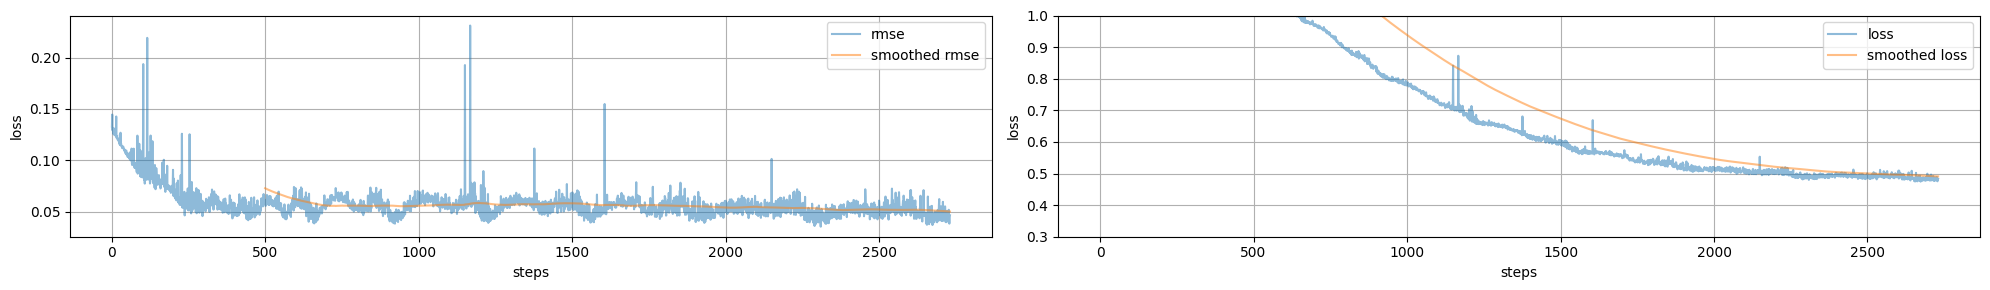

In [23]:
def ploth(h, name='loss', ylim=None, ax=None):
    lossp = pd.DataFrame(h, columns=[name])
    lossp[f'smoothed {name}'] = lossp[name].rolling(500).mean()
    lossp.plot(alpha=.5, ax=ax)
    plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
    if ylim is not None:
        plt.ylim(*ylim)
        
for ax,i in subplots(2, usizex=10):
    if i==0: ploth(np.r_[rmseh], name='rmse', ax=ax)#, ylim=(-.01,15))
    if i==1: ploth(lossh, name='loss', ax=ax, ylim=(0.3,1.))

In [24]:
o[-5:]

tensor([[-0.1261,  0.0186,  0.0997,  ...,  0.0201, -0.1101,  0.0504],
        [-0.1049,  0.0159,  0.0847,  ...,  0.0174, -0.0911,  0.0428],
        [-0.1300,  0.0160,  0.1032,  ...,  0.0205, -0.1099,  0.0496],
        [-0.1143,  0.0056,  0.1051,  ...,  0.0137, -0.0802,  0.0402],
        [-0.1143,  0.0056,  0.1051,  ...,  0.0137, -0.0802,  0.0402]],
       grad_fn=<SliceBackward0>)

In [25]:
t[-5:]

tensor([[-0.1583,  0.0276,  0.1355,  ...,  0.0107, -0.1429,  0.0407],
        [-0.1343,  0.0416,  0.1392,  ..., -0.0036, -0.1207,  0.0371],
        [-0.1745,  0.0249,  0.1663,  ..., -0.0098, -0.1233,  0.0368],
        [-0.1450,  0.0254,  0.1463,  ..., -0.0100, -0.0950,  0.0159],
        [-0.1609,  0.0214,  0.1506,  ..., -0.0053, -0.1127,  0.0307]])

## visualize targets vs predictions on random chips

In [26]:
b = next(iter(dl.train_dataloader()))
b.keys()

/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py:183: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


dict_keys(['multilabel', 'embedding', 'osm_strlabels', 'osm_ohearea', 'osm_ohecount', 'osm_ohelength'])

In [27]:
tr_targets = b['embedding'].numpy()[:16]
tr_predictions = m(b).detach().numpy()[:16]

In [28]:
conf.training.loss, len(tr_targets)

('rmse', 16)

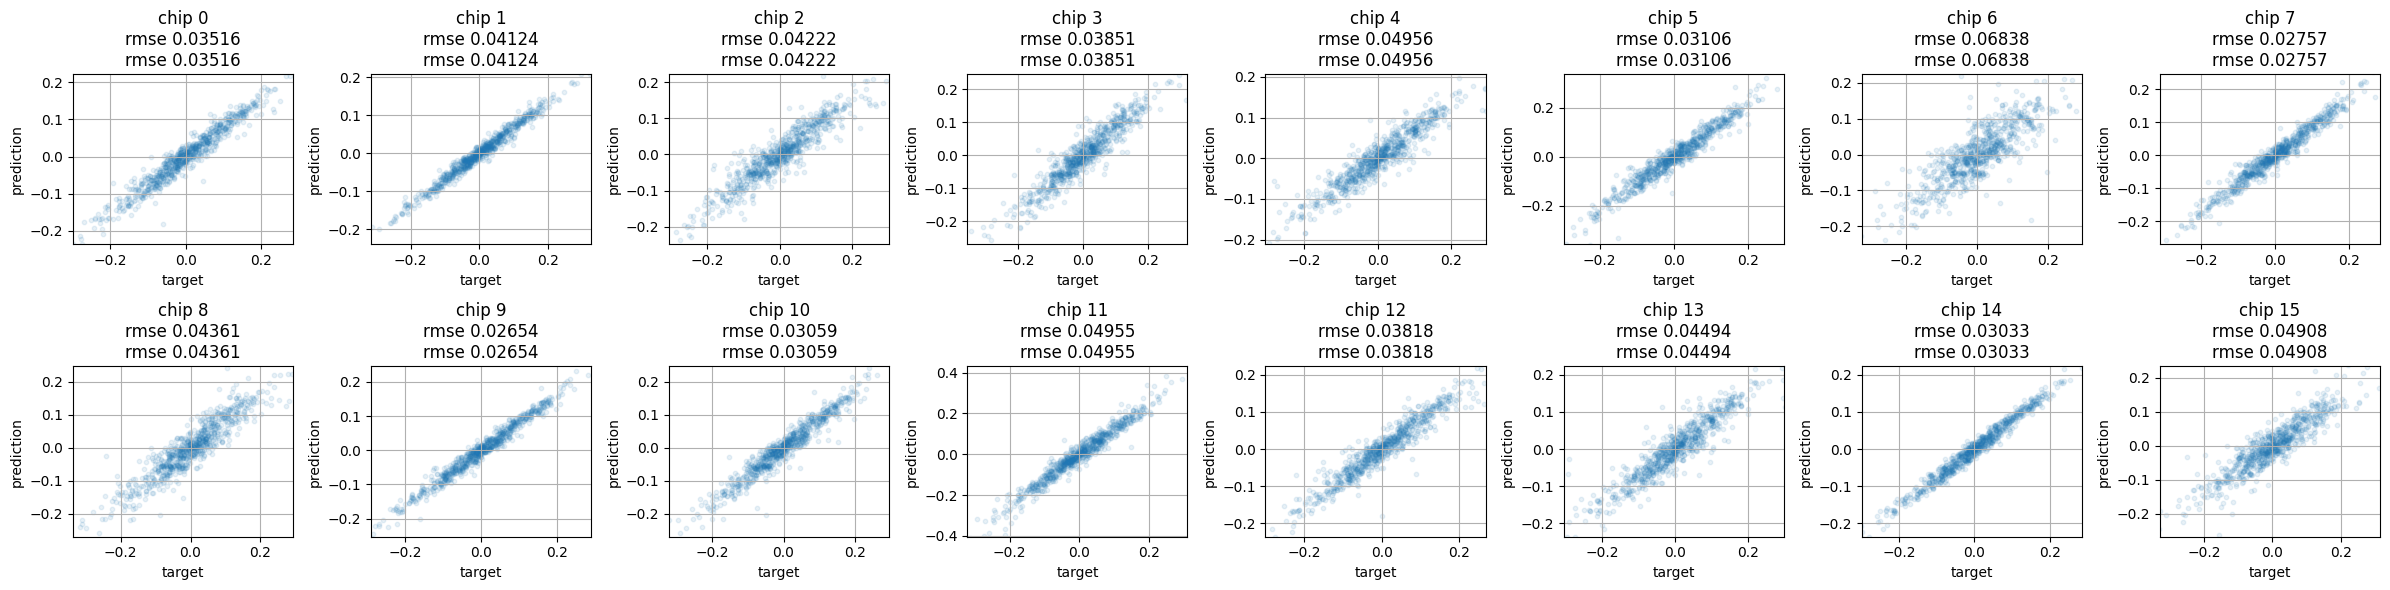

In [29]:
for ax,i in subplots(len(tr_targets), n_cols=8):
    idx = i
    t = tr_targets[idx]
    p = tr_predictions[idx]
    plt.scatter(t, p, alpha=.1, s=10)
    plt.grid()
    plt.xlabel("target")
    plt.ylabel("prediction")
    rmse = np.sqrt(np.mean ( (t-p)**2 ))
    logr = loss_funcs[conf.training.loss](torch.tensor(t),torch.tensor(p))
    plt.title(f"chip {idx}\nrmse {rmse:.5f}\n{conf.training.loss} {logr:.5f}")
    ta,tb = np.percentile(t, [1,99])
    pa,pb = np.percentile(p, [1,99])
    plt.xlim(ta, tb)
    plt.ylim(pa, pb)


## measure loss on full train,val,test datasets

In [30]:
def get_targets_and_predictions(dataloader):
    targets = []
    predictions = []
    inputs = []
    for batch in pbar(dataloader):
        t = batch['embedding']
        o = m(batch)
        x = m.make_input(batch)
    
        for ti in t.detach().numpy():
            targets.append(ti)
    
        for oi in o.detach().numpy():
            predictions.append(oi)

        for xi in x.detach().numpy():
            inputs.append(xi)
        
    targets = np.r_[targets]
    predictions = np.r_[predictions]
    inputs = np.r_[inputs]
    return targets, predictions, inputs

In [31]:
dl.disable_chip_loading()
tr_targets, tr_predictions, tr_inputs = get_targets_and_predictions(dl.train_dataloader())

/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py:183: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
100% (2259 of 2259) |####################| Elapsed Time: 0:00:18 Time:  0:00:180001


In [32]:
dl.disable_chip_loading()
dataloader = dl.test_dataloader()


In [33]:
ts_targets, ts_predictions, ts_inputs = get_targets_and_predictions(dl.test_dataloader())
val_targets, val_predictions, val_inputs = get_targets_and_predictions(dl.val_dataloader())

/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py:183: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
100% (538 of 538) |######################| Elapsed Time: 0:00:05 Time:  0:00:050000
/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py:183: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect it

In [34]:
regr_to_mean_tr = tr_targets.mean(axis=0)
v = loss_funcs['rmse']
print (f"rmse regr to mean {v(torch.tensor(tr_targets), torch.tensor(regr_to_mean_tr)):.5f}")
print (f"rmse train        {v(torch.tensor(tr_targets), torch.tensor(tr_predictions)):.5f}")
print (f"rmse test         {v(torch.tensor(ts_targets), torch.tensor(ts_predictions)):.5f}")
print (f"rmse val          {v(torch.tensor(val_targets), torch.tensor(val_predictions)):.5f}")

rmse regr to mean 0.04062
rmse train        0.04732
rmse test         606496.12500
rmse val          314150.25000


## compare random pairs

In [35]:
def similarity(a,b):
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    return a.dot(b) 

In [36]:
i1,i2 = np.random.permutation(len(tr_targets))[:2]

100% (10000 of 10000) |##################| Elapsed Time: 0:00:09 Time:  0:00:090000
100% (10000 of 10000) |##################| Elapsed Time: 0:00:02 Time:  0:00:020000
100% (10000 of 10000) |##################| Elapsed Time: 0:00:02 Time:  0:00:020000


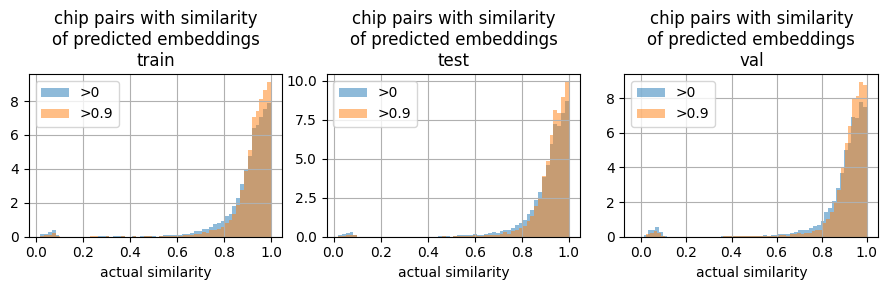

In [37]:
targets, predictions = tr_targets, tr_predictions

for ax, i in subplots(3):
    if i==0: targets, predictions, split_name = tr_targets, tr_predictions, "train"
    if i==1: targets, predictions, split_name = ts_targets, ts_predictions, "test" 
    if i==2: targets, predictions, split_name = val_targets, val_predictions, "val"


    r = []
    for _ in pbar(range(10000)):
        i1,i2 = np.random.permutation(len(targets))[:2]
        simt = similarity(targets[i1], targets[i2])
        simp = similarity(targets[i1], predictions[i2])
        r.append([simt, simp])
    r = np.r_[r]
    r = pd.DataFrame(r, columns=['sim', 'sim_osmencoder'])
    
    thr = 0.9
    for thr in [0, 0.9]:
        rr = r[r['sim_osmencoder']>thr]
        plt.hist(rr['sim'], bins=60, density=True, alpha=.5, label=f">{thr}");
    plt.title(f"chip pairs with similarity\nof predicted embeddings\n{split_name}")
    plt.xlabel("actual similarity")
    plt.grid()
    plt.legend();

Text(0, 0.5, 'a-similarity')

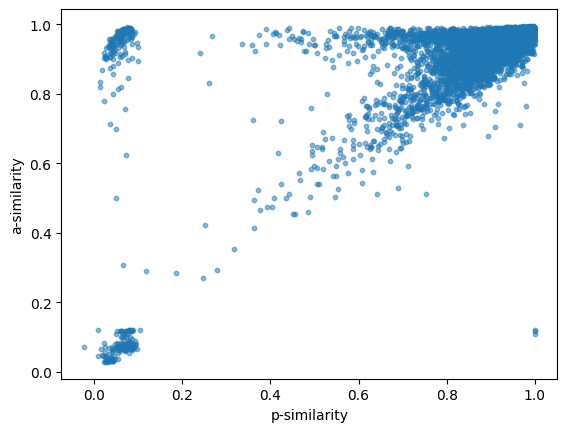

In [38]:
plt.scatter(r['sim'], r['sim_osmencoder'], s=10, alpha=.5)
plt.xlabel("p-similarity")
plt.ylabel("a-similarity")